<h1>Structural Variation Pipeline Tutorial</h1>

This tutorial provides an introduction to the detection and analysis of structural variation (SV) from Oxford Nanopore Technologies whole human genome sequencing experiments. The tutorial walks through and introduces the steps involved in SV detection, filtering and refinement. The workflow introduced uses a human alignment dataset (`.bam` file) as its starting point. 

Computational requirements for this tutorial include:

* Computer running the EPI2ME Labs notebook Server
* At least 16Gb RAM

> ⚠️ Warning: This notebook has been saved with its outputs for demostration purposed. It is recommeded to select Edit > Clear all outputs before using the notebook to analyse your own data.

## Introduction

Long read DNA sequences, when mapped to a reference genome, can be used for the discovery and characterisation of structural variation. This is achieved by investigating discordant mapping where regions of a single sequenced DNA molecule map to different regions of the genome. Software packages such as `sniffles` identify these discordant regions and can be used to call insertions, deletions, duplications, inversion and translocations. 

This tutorial is based on the Oxford Nanopore Technologies [pipeline-structural-variation](https://github.com/nanoporetech/pipeline-structural-variation) software. This analysis pipeline utilises the [sniffles](https://github.com/fritzsedlazeck/Sniffles) software and may be used to identify high confidence genomic insertion, duplication and deletion events.

The tutorial is packaged with example data from the [Genome in a Bottle](https://www.nist.gov/programs-projects/genome-bottle) project ([GM24385](https://www.coriell.org/0/Sections/Search/Sample_Detail.aspx?Ref=GM24385&Product=CC)). The analysis considers a collection of sequence reads that map to a 50 Mb region from Chromosome 20.

The workflow covered in this tutorial will:

* Assess a mapping `.bam` file for qualitative characteristics including mapping quality, number of mapped reads and depth-of-coverage.
* Identify a set of permissive SVs relative to a human reference genome using `sniffles`.
* Refine the set of SVs to produce a high quality subset in a VCF format file.

The tutorial workflow will answer questions such as:

* How many sequence reads map to the reference genome?
* What is the depth of sequence coverage across the genome?
* How many SVs can be identified, what is their size distribution, and how frequent are the different types of SV?

## Getting started

The structural variation tutorial requires an indexed `.bam` format sequence alignment file from long read whole genome human sequencing data. An example dataset is provided with this workflow.
 
This tutorial does not introduce mapping sequence reads to a reference genome. This topic is covered in the [Cas9 Targeted Sequencing](https://colab.research.google.com/github/epi2me-labs/tutorials/blob/master/targeted_sequencing.ipynb) tutorial where **`mini_align`** from the [Pomoxis](https://nanoporetech.github.io/pomoxis/index.html) software is used to run [minimap2](https://github.com/lh3/minimap2). Mapping is also the subject of an upcoming tutorial.

Before anything else we will create and set a working directory:

In [3]:
from epi2melabs import ping
pinger = ping.Pingu()
pinger.send_notebook_ping('start', 'sv_tutorial')

# create a work directory and move into it
tutorial_name = "sv_tutorial"
working_dir = "/epi2melabs/{}/".format(tutorial_name)
!mkdir -p "$working_dir"
%cd "$working_dir"

/epi2melabs/sv_tutorial


### Sample data

To demonstrate this structural variation workflow a small dataset is provided. This dataset corresponds to sequence reads from the GM12878 human reference material that have been mapped to the hg19 reference genome. This version of the reference genome has been selected to enable the benchmarking of SV-calling performance against the [Genome In a Bottle](https://www.nist.gov/programs-projects/genome-bottle) truthset. To facilitate a quick analysis and speedy download the whole dataset has been downsampled to a 50 Mb region of chromosome 20. 

The code below will download the sample `.bam` mapping data and its corresponding index. The `wget` command is used to download the files.  

To execute the commands click on the cell and then press Command/Ctrl-Enter, or click the Play symbol to the left-hand side. 

In [ ]:
import os

# download the data
location='s3://ont-exd-int-s3-euwst1-epi2me-labs/sv_tutorial'
s3_bucket = "ont-exd-int-s3-euwst1-epi2me-labs"
s3_prefix = "sv_tutorial/GM24385.nf7.chr20_af_minimap2.bam"
s3_bedfile = "sv_tutorial/target.bed"
filename = os.path.basename(s3_prefix)
!echo "Downloading sample data"
!wget -O "$filename" https://"$s3_bucket".s3.amazonaws.com/"$s3_prefix"
!wget -O "$filename".bai https://"$s3_bucket".s3.amazonaws.com/"$s3_prefix".bai
!wget -O "target.bed" https://"$s3_bucket".s3.amazonaws.com/"$s3_bedfile"

### Using your own data

If you wish to analyse your own data rather than the sample data, you can edit the value `.fastq input` variable below. To find the correct full path of a directory you can navigate to it in
the `Files` browser to the left-hand side, right-click on the file and select `Copy path`:

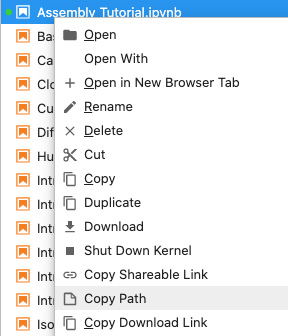

The location shared with the EPI2ME labs server from your computer will show as `/epi2melabs`, for example a file located at `/data/my_gridion_run/fastq_pass` on your computer will appear as `/epi2melabs/my_gridion_run/fastq_pass` when it is the `/data` folder that is shared.





## Data input

Having downloaded the sample data, or locating your own data in the file browser, we need to provide the appropriate file location as input to the notebook.

The form below can also be edited to tune the characteristics of the SV analysis.

* `alignment_bam` is the sorted and indexed `.bam` mapping file. ❗**IMPORTANT**: Alignments must contain supplementary alignments as they are used in this analysis.
* `target_bed` is a `.bed` coordinate file that defines the genomic regions of interest. If you do not wish to filter by a region leave this field empty. See the appendix for more details.
* `sample_name` is an arbitrary name for the analysis; please use appropriate names when running your own samples.
* `threads` defines the number of compute threads that will be used by the processes that can multi-thread. Please do not use more threads than are available on your computer. 
* `min_sv_length` and `max_sv_length` defines the length of the shortest and longest allowable structural variations respectively.
* `mean_read_mapping_quality` is a cutoff for the minimum read mapping quality that will be considered for the calculation of SVs.

In [1]:
import multiprocessing
import os

import aplanat
from aplanat import report, graphics
import ipywidgets as widgets
from epi2melabs.notebook import InputForm, InputSpec, cecho

alignment_bam = None
target_bed = None
sample_name = None
threads = None
min_sv_length = None
max_sv_length = None
min_read_support = None
min_read_length = None
min_read_mapping_quality = None
high_conf_bed = "HG002_SVs_Tier1_v0.6.bed"
html_report = None
exec_summary = None

def process_form(inputs):
    global alignment_bam, target_bed, sample_name, threads, \
        min_sv_length, max_sv_length, min_read_support, \
        min_read_length, min_read_mapping_quality, \
        html_report, exec_summary
    alignment_bam = inputs.alignment_bam
    target_bed = inputs.target_bed
    sample_name = inputs.sample_name
    threads = inputs.threads
    min_sv_length = inputs.min_sv_length
    max_sv_length = inputs.max_sv_length
    min_read_support = inputs.min_read_support
    min_read_length = inputs.min_read_length
    min_read_mapping_quality = inputs.min_read_mapping_quality
    
    if not os.path.isfile(alignment_bam):
        !cecho error "Alignment bam '{}' does not exist.".format(alignment_bam)
    if not os.path.isfile(alignment_bam + '.bai'):
        !cecho error "Alignment bam index '{}' does not exist.".format(alignment_bam + '.bai')
    if target_bed != "" and not os.path.isfile:
        !cecho error "Target bed file '{}' does not exist.".format(target_bed)
    if " " in sample_name:
        !cecho error "Sample name must not contain spaces...")
    else:
        !echo "Making output directory: $sample_name" && mkdir -p "$sample_name"
        
    if min_sv_length < 0 or max_sv_length <= 0 or min_read_mapping_quality < 0:
        !echo error "Invalid value(s) given for `min_sv_length`, `max_read_length`, or `min_read_mapping_quality`."
        
    html_report = report.HTMLReport(
        "Structural Variation", "Summary of read alignments and SV discovery.",
        require_keys=True)
    html_report.markdown("## Executive Summary", "exec-title")
    html_report.placeholder("exec-plot")
    exec_summary = graphics.InfoGraphItems()
    !cecho success "Input validation complete"


input_form = InputForm(
    InputSpec('alignment_bam', '.bam alignment file', 'GM24385.nf7.chr20_af_minimap2.bam'),
    InputSpec('target_bed', '.bed target file', 'target.bed'),
    InputSpec('sample_name', 'Sample name', 'my_sample'),
    InputSpec('threads', 'Compute threads', (1, multiprocessing.cpu_count(), 1)),
    InputSpec('min_sv_length', 'Minimum SV length to report', widgets.IntText(40)),
    InputSpec('max_sv_length', 'Maximum SV length to report', widgets.IntText(1000000)),
    InputSpec('min_read_length', 'Minimum read length', widgets.IntText(1000)),
    InputSpec('min_read_support', 'Minimum reads to support variant', widgets.IntText(3)),
    InputSpec('min_read_mapping_quality', 'Minimum read mapping quality', widgets.IntText(20)),
    description_width="200px")
input_form.add_process_button(process_form)
input_form.display()



### Preliminary Analysis
Before calling structural variants in our dataset it is worthwhile to review the key quality characteristics from our starting `.bam`  file.

The `seqkit bam` method is used to prepare a collection of per read-alignment summary observations. These observations will be presented as figures and tables that describe the distribution of mapping qualities, depths of coverage and summarise the numbers of reads and sequence bases that map to the reference genome.

In [ ]:
seqkit_stats = "{}.seqkit.tsv".format(alignment_bam)
!seqkit bam $alignment_bam 2> "$seqkit_stats"
!head "$seqkit_stats"

Using the output from `seqkit` we can derive some basic statistics concerning the alignments of reads to the reference sequence:

In [6]:
# Read summary plot code (click play)
# calculate some basic statistics from the alignments
import aplanat
from aplanat import hist
from bokeh.layouts import gridplot
import numpy as np
import pandas as pd
import sys

pd.options.display.float_format = '{:.2f}'.format

def parse_seqkit(fname):
    cols = {
        'Read':str, 'MapQual':int, 'Acc':float, 'ReadLen':int,
        'ReadAln':int, 'ReadCov':float, 'MeanQual':float,
        'IsSec':bool, 'IsSup':bool}
    df = pd.read_csv(fname, sep="\t", dtype=cols, usecols=cols.keys())
    df['Clipped'] = df['ReadLen'] - df['ReadAln']
    df['Type'] = 'Primary'
    df.loc[df['IsSec'], 'Type'] = 'Secondary'
    df.loc[df['IsSup'], 'Type'] = 'Supplementary'
    return df

def summarize_seqkit(df):
    grouped = df.groupby('Type').agg(**{
        'Alignments': ('Read', 'count'),
        'Unique Reads': ('Read', 'nunique'),
        'Ave. read length': ('ReadLen', 'median'),
        'Ave. read quality': ('MeanQual', 'median'),
        'Ave. mapping quality': ('MapQual', 'median'),
        'Ave. align length': ('ReadAln', 'median'),
        'Total aligned bases': ('ReadAln', 'sum'),
        'Total clipped bases': ('Clipped', 'sum')})
    grouped.loc[['Secondary', 'Supplementary'],
        ['Ave. read length', 'Ave. read quality']] = "-"
    return grouped.transpose()

seqkit_df = parse_seqkit(seqkit_stats)
summary_table = summarize_seqkit(seqkit_df)
primarys = seqkit_df.loc[seqkit_df['Type'] == 'Primary']

p1 = hist.histogram(
    [primarys['Acc']], xlim=(70, 101), binwidth=0.5,
    height=250, width=400,
    x_axis_label='read accuracy', y_axis_label='read count')
p2 = hist.histogram(
    [primarys['ReadCov']], xlim=(90, 101), binwidth=0.2,
    height=250, width=400,
    x_axis_label='% of read contained in alignment',
    y_axis_label='read count')
alignment_plots = gridplot([p1, p2], ncols=2)
display(summary_table)
aplanat.show(alignment_plots)

prim = summary_table["Primary"]
exec_summary.append(
    "Primary alignments", prim.loc["Alignments"], "signal")
exec_summary.append(
    "Ave. read quality", prim.loc["Ave. read quality"], "thumbs-up")
exec_summary.append(
    "Ave. read length", prim.loc["Ave. read length"], "align-center", "b")

# Add plot to the html report
html_report.markdown("""
### Read alignments.

Summary of read alignments to the reference genome. Note that read-based
statistics (e.g `Ave. read length`) are not reported for secondary and
supplementary alignments where they would otherwise overcount.""",
"align-head")
html_report.table(summary_table, index=True, key="align-table")
html_report.markdown("""
#### Primary alignment statistics

The following plots give an overall impression of read quality. Accuracy should show a strong peak
above 93% with alignment containment above 98%.""",
"align-stat-head")
html_report.plot(alignment_plots, "align-plot")

Type,Primary,Secondary,Supplementary
Alignments,88892,5688,4703
Unique Reads,88892,1905,2344
Ave. read length,6922,-,-
Ave. read quality,10.77,-,-
Ave. mapping quality,60,0,40
Ave. align length,6761,1460,1197
Total aligned bases,1625708285,24673658,26799695
Total clipped bases,42299549,149612797,253368166


## Calling Structural Variants

A first step in calling structural variants is to permissively call all possible structural variants. We will use `sniffles` for this purpose. In the code block below, `sniffles` is called with parameters that define the minimum read length, minimum read support, and minimum mapping quality.  

* `min_read_length` is a minimum threshold for read lengths. This is used to reject the shortest mapping sequences and is by default defined as 1000 nucleotides.
* `read_support` is a minimum threshold for the number of required supporting reads. The default value requires that three of more reads cover an SV.
* `min_read_mapping_quality` was defined in the configuration form at the top of the analysis section (a value of 20 by default) and is a minimum threshold used to reject reads with lower quality mapping scores.

These parameters are permissive and will produce a large number of candidate SVs. This is intentional and subsequent steps in the workflow will qualitatively filter and refine the SV collection.


In [ ]:
# Finding candidate variants with sniffles (click play)
import os

sv_calls_dir = os.path.join(sample_name, "sv_calls")
!mkdir -p "$sv_calls_dir"
temp_sniffles_vcf = "{}_sniffles_tmp.vcf".format(sample_name)
sniffles_tmp = os.path.join(sv_calls_dir, temp_sniffles_vcf)

cmd = f"sniffles  -m {alignment_bam}  -v {sniffles_tmp}  -s {min_read_support}  -r {min_read_length}  -q {min_read_mapping_quality}  --genotype --report_read_strands"
!cecho ok "Running $cmd"
!$cmd

### Filtering SVs for depth and length

The complete set of SVs from `sniffles` can be filtered to regions of interest using the `.bed` file specified in the sections above. This allows for targeted SV analyses in specific regions of interest. At this step we will also run `sniffles-edit` to ensure the VCF file is compatible with tools such as the Integrative Genome Viewer ([IGV](http://software.broadinstitute.org/software/igv/)).

In [48]:
# Filtering sniffles' `.vcf` by regions within a `.bed` (click play)
#filter region
vcf_region_filtered = "{}_sniffles_region_filtered.vcf".format(sample_name)
vcf_region_filtered = os.path.join(sv_calls_dir, vcf_region_filtered)
# if target_bed is specified we filter by the regions included in target_bed
if target_bed != "":
    print("Filtering .vcf by .bed...")
    !bcftools view -T $target_bed $sniffles_tmp -o $vcf_region_filtered
else:
    !cp $sniffles_tmp $vcf_region_filtered

# reformat vcf for compatibility with IGV
# TODO: put this back, and in its own cell
#vcf_sniffles = vcf_region_filtered
print("Preparing cleaned sniffles vcf...")
vcf_sniffles = os.path.join(sv_calls_dir, "{}_sniffles.vcf".format(sample_name))
!run sniffles-edit --ins-length --check --vcf-version \
  -v $vcf_region_filtered -o $vcf_sniffles
print("Done")

Filtering .vcf by .bed...
Preparing cleaned sniffles vcf...


To avoid false positive calls due to low read coverage we will now assess the read depth across the regions in the dataset using the `mosdepth` tool:

In [49]:
# Running mosdepth to calculate read coverage (click play)
!mkdir -p "depth"
if target_bed != "":
    bed_opt = "-b {}".format(target_bed)
else:
    bed_opt = ""
!mosdepth -n -x $bed_opt -t $threads \
    depth/"$sample_name" "$alignment_bam"

Using the average read depth we can compute a minimum read depth required to call variants. The code below first attempts to establish a bound using a fraction (`min_support_frac`) of the average sequencing depth. If this lower that a minimum bound (`min_support`), then the higher value is chosen.

The original `.vcf` file produced by sniffles can now be filtered by the depth threshold reported above. At this stage we filter also by the minimum and maximum lengths specified at the start of this tutorial. In addition variant calls are filtered based on strand support and allelic frequencies. The strand support filter uses Fischer's exact test to remove SV calls with extreme strand bias. An example of this would be where SV calls occur in a small number of forward strands but never on the reverse despite the total depth being made up of and equal number of forward and reverse reads. SV calls with less than the given allelic frequency will be filtered out.

In [2]:
min_rs = None
vcf_sniffles_filtered_gz = None
def get_rs(inputs):
    global min_rs
    global vcf_sniffles_filtered_gz
    mosdepth_file = os.path.join("depth", "{}.regions.bed.gz".format(sample_name))
    depth_table = pd.read_csv(
        mosdepth_file, 
        compression="gzip", 
        sep="\t", 
        header=None, 
        names=("chr", "start", "end", "avg_depth"))

    depth_table["length"] = depth_table["end"] - depth_table["start"]
    # sum depth is used here to weight it based on length of region (chromosome)
    depth_table["sum_depth"] = depth_table["length"] * depth_table["avg_depth"]
    total_bases = sum(depth_table["length"])
    sum_depth = sum(depth_table["sum_depth"])
    min_rs = round((sum_depth / total_bases * inputs.min_support_frac))

    if min_rs < inputs.min_support:
        print("Min read support {} not allowed. "
              "Falling back to minimum of {}.".format(min_rs, min_rs_limit))
        min_rs = inputs.min_support

    statement = "Setting min. read support to {} for overall read depth of {}"
    statement = statement.format(min_rs, round((sum_depth / total_bases)))
    print(statement)
    
    sv_types = []
    if inputs.include_del:
        sv_types.append('DEL')
    if inputs.include_ins:
        sv_types.append('INS')
    if inputs.include_dup:
        sv_types.append('DUP')
    sv_types = ' '.join(sv_types)

    vcf_sniffles_filtered_tmp = "{}_sniffles_filtered_tmp.vcf".format(sample_name)
    vcf_sniffles_filtered_tmp = os.path.join(sv_calls_dir, vcf_sniffles_filtered_tmp)

    cmd = f"sniffles-filter -v {vcf_sniffles} -m {min_rs} -t {sv_types} --strand-support {inputs.strand_support} " \
        f"-l {min_sv_length} --min-af {inputs.allelic_frequency} --max-length {max_sv_length} -o {vcf_sniffles_filtered_tmp}"
    !cecho ok "Running: $cmd"
    !run $cmd

    #sort vcf
    vcf_sniffles_filtered = "{}_sniffles_filtered.vcf".format(sample_name)
    vcf_sniffles_filtered = os.path.join(sv_calls_dir, vcf_sniffles_filtered)
    print("Sorting VCF...")
    !bcftools sort "$vcf_sniffles_filtered_tmp" > "$vcf_sniffles_filtered"
    vcf_sniffles_filtered_gz = "{}.gz".format(vcf_sniffles_filtered)
    print("Indexing VCF...")
    !bgzip -f "$vcf_sniffles_filtered"
    !bcftools index "$vcf_sniffles_filtered_gz"
    print("Done")
        
support_form = InputForm(
    InputSpec('min_support_frac', 'Minimum support fraction', widgets.FloatSlider(min=0, max=1.0, step=0.1, value=0.2)),
    InputSpec('min_support', 'Minimum supporting reads', widgets.IntText(3)),
    InputSpec('include_del', "Include deletions", True),
    InputSpec('include_ins', "Include insertions", True),
    InputSpec('include_dup', "Include duplications", True),
    InputSpec('strand_support', "Strand support", widgets.FloatSlider(min=0, max=0.2, step=0.01, value=0.01)),
    InputSpec('allelic_frequency', "Allelic frequency", widgets.FloatSlider(min=0, max=1.0, step=0.05, value=0.1)),
    description_width="200px", widget_width='220px')
support_form.add_process_button(get_rs)
support_form.display()    

## Analysis

In this section we will analyse the called and filtered variants. There are many more interesting things which can be learnt from the variant calls, including specific biological questions of interest. Here however we focus on simple, generic properties of the discovered variants.

To start we can generate plots indicating the occurence and density of SVs throughout the genome:

In [78]:
# Plotting SV density karyograms (click play)
import aplanat
from aplanat import bio
import pandas as pd
import numpy as np

def parse_vcf(fname):
    header = "CHROM POS ID REF ALT QUAL FILTER INFO FORMAT GT".split()
    vcf = pd.read_csv(fname, delimiter='\t', comment='#', names=header, dtype={'CHROM':str})
    #print(vcf.head())
    # The INFO field isn't quite a table, so this is cumbersome
    info = vcf['INFO'].str.split(pat=";",expand=True, n=1)
    vcf['STATUS'] = info[0]
    vcf['details'] = info[1].str.split(";").apply(lambda x: dict([y.split("=") for y in x]))
    for field in ['SVTYPE', 'SUPTYPE', 'SVLEN']:
        vcf[field] = vcf['details'].apply(lambda x: x[field])
    # filter to chromosome
    allowed = [str(x) for x in range(1,23)] + ['X','Y']
    vcf = vcf.loc[vcf['CHROM'].isin(allowed)]
    for orig, rename in (('INS', 'Insertion'), ('DEL', 'Deletion'), ('DUP', 'Duplication')):
        vcf.loc[vcf['SVTYPE'] == orig, 'SVTYPE'] = rename
    vcf['SVLEN'] = vcf['SVLEN'].astype(int)
    return vcf

sv_types = ('Insertion', 'Deletion', 'Duplication')
sv_colours = ['red', 'green', 'blue']
karyograms = list()
for sv, col in zip(sv_types, sv_colours):
    data = vcf.loc[vcf['SVTYPE'] == sv]
    plot = bio.karyotype(
        [data['POS']], [data['CHROM']], [sv], [col], alpha=0.2,
        height=300, width=400)
    karyograms.append(plot)
karyograms = gridplot(karyograms, ncols=3)

aplanat.show(karyograms)
html_report["Karyogram plots:"] = karyograms

For a more quantitative view of the data, let us examine the length distributions of the called variants separated by type:

In [79]:
# SV length distributions (click play)

vcf_summary = vcf.groupby('SVTYPE').agg(**{
        'Count': ('POS', 'count'),
        'Min. Length': ('SVLEN', lambda x: np.min(x.abs())),
        'Ave. Length': ('SVLEN', lambda x: np.median(x.abs())),
        'Max. Length': ('SVLEN', lambda x: np.max(x.abs()))}).transpose()
html_report.markdown("""
### Structural Variants

The structural variants found by the analysis and reported
in the output `.vcf` are summarized below.""",
'sv-summary-head')
html_report.table(vcf_summary, index=False, key='sv-summary-table')
exec_summary.append('Variants found', int(sum(vcf_summary.loc['Count'])), 'balance-scale')

length_plots = list()
for sv, col in zip(sv_types, sv_colours):
    data = np.log10(vcf.loc[vcf['SVTYPE'] == sv, 'SVLEN'].abs())
    plot = hist.histogram(
        [data], colors=[col],
        names=[sv], bins=200, xlim=(1, None),
        height=250, width=400,
        title="{} SV lengths".format(sv),
        x_axis_label='log10(SV length / bases)',
        y_axis_label='count')
    length_plots.append(plot)
length_plots = gridplot(length_plots, ncols=2)
html_report.plot(length_plots, key='sv-len-plots')

display(vcf_summary)
aplanat.show(length_plots)

SVTYPE,Deletion,Duplication,Insertion
Count,197.00,8.00,228.00
Min. Length,41.00,74.00,41.00
Ave. Length,83.00,374.50,162.00
Max. Length,53562.00,34139.00,5876.00


## Headline Numbers

As a final summary of the experiment the infographic below displays a small set of headline numbers captured through the course of the analysis. Running the codecell will produce also a standalone HTML report document in the output folder.

In [81]:
# Executive summary (click play)
pinger.send_notebook_ping('stop', 'sv_tutorial')
exec_plot = graphics.infographic(exec_summary.values())
aplanat.show(exec_plot)

html_report['exec-plot'] = exec_plot
html_report_path = "report.html"
html_report.write(html_report_path)
print("Report written to {}".format(os.path.abspath(html_report_path)))

Report written to /epi2melabs/sv_tutorial/report.html


## Summary

This tutorial has stepped through the calling an summary analysis of structural variants implied by an Oxford Nanopore long read dataset. Using the sniffles package to call variants the types, lengths, and location of variants has been explored.

The analysis presented can be run on any `.bam` alignment file generated by `minimap2` which retains secondary and supplementary alignments.


## Appendix 

**Example code for the preparation of a bed file**

In the workflow form at the head of this tutorial a requirement for a BED coordinate file was introduced. An appropriate `.bed` file may be prepared from a `.fasta` format reference genome with the following command.

```
$ pip install pyfaidx  
$ faidx --transform bed test.fasta > test.bed
```